In [25]:
!pip install statsforecast
!pip install fugue
!pip install numpy==1.23.5

In [1]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
from statsforecast.distributed.utils import forecast
from statsforecast.distributed.fugue import FugueBackend
from statsforecast.models import *
from statsforecast.core import *

/opt/bitnami/python/lib/python3.8/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
spark = SparkSession.builder.appName("Vu dep trai").config("spark.executor.memory","10g").getOrCreate()
# conf = pyspark.SparkConf().setMaster("spark://node-master:7077")\
#         .setAppName("Vu dep trai")\
#         .set("spark.executor.memory","15g")
# # sc = SparkContext.getOrCreate(conf=conf)
# sc = SparkContext(conf = conf)
# spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 18:29:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [69]:
list_ticker = os.listdir("./raw_data/")
ticker = list_ticker[0]

df = spark.read.json("./raw_data/"+ticker)
df = df.withColumn("trading_date", to_utc_timestamp("trading_date", "GMT+7"))
df = df.withColumnRenamed("ticker_name", "unique_id").sort("trading_date")

In [71]:
df.show(10)

+-----------+----------+---------+----------+---------+-------------------+------+
|close_price|high_price|low_price|open_price|unique_id|       trading_date|volume|
+-----------+----------+---------+----------+---------+-------------------+------+
|     9063.0|    9242.0|   8581.0|    8416.0|      C69|2017-04-20 17:00:00|716100|
|     9970.0|   10277.0|   9476.0|    9387.0|      C69|2017-04-23 17:00:00|852700|
|    10941.0|   11125.0|  10401.0|   10358.0|      C69|2017-04-24 17:00:00|349800|
|     9905.0|   10934.0|   9898.0|    9905.0|      C69|2017-04-25 17:00:00|445000|
|     8934.0|    8934.0|   8934.0|    8934.0|      C69|2017-04-26 17:00:00|365600|
|     8092.0|    8092.0|   8092.0|    8092.0|      C69|2017-04-27 17:00:00|321500|
|     7315.0|    7315.0|   7315.0|    7315.0|      C69|2017-05-02 17:00:00| 21300|
|     6603.0|    6603.0|   6603.0|    6603.0|      C69|2017-05-03 17:00:00| 23601|
|     5956.0|    5956.0|   5956.0|    5956.0|      C69|2017-05-04 17:00:00|534201|
|   

In [49]:
ratio_train = 0.8
n_train = int(df.count() * ratio_train)
n_valid = df.count() - n_train
df_train = df.orderBy("trading_date").limit(n_train)
df_valid = df.subtract(df_train)

In [50]:
df_close_train = df_train.select("unique_id", "trading_date", "close_price")
df_close_train = df_close_train.withColumnRenamed("close_price", "y").withColumnRenamed("trading_date", "ds")
df_close_test = df_valid.select("unique_id", "trading_date", "close_price")
df_close_test = df_close_test.withColumnRenamed("close_price", "y").withColumnRenamed("trading_date", "ds")
df_close_train.show(5)

+---------+-------------------+-------+
|unique_id|                 ds|      y|
+---------+-------------------+-------+
|      C69|2017-04-20 17:00:00| 9063.0|
|      C69|2017-04-23 17:00:00| 9970.0|
|      C69|2017-04-24 17:00:00|10941.0|
|      C69|2017-04-25 17:00:00| 9905.0|
|      C69|2017-04-26 17:00:00| 8934.0|
+---------+-------------------+-------+
only showing top 5 rows



/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


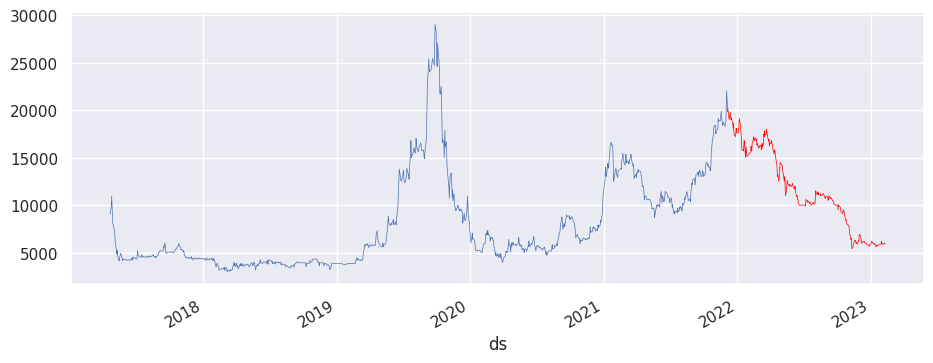

In [51]:
sns.set(rc={'figure.figsize':(11, 4)})
df_close_train.toPandas().set_index('ds').y.plot(linewidth=0.5)
df_close_test.toPandas().set_index('ds').y.plot(linewidth=0.5, c='red')
plt.show()

In [58]:
backend = FugueBackend(spark, {"fugue.spark.use_pandas_udf":True})
preds = forecast(df_close_train, 
         [AutoARIMA(num_cores=-1)], 
         freq="D", 
         h=n_valid,
         parallel=backend).toPandas()
preds.head()

/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,unique_id,ds,AutoARIMA
0,C69,2021-12-07 17:00:00,20481.794922
1,C69,2021-12-08 17:00:00,20481.794922
2,C69,2021-12-09 17:00:00,20481.794922
3,C69,2021-12-10 17:00:00,20481.794922
4,C69,2021-12-11 17:00:00,20481.794922


/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/bitnami/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


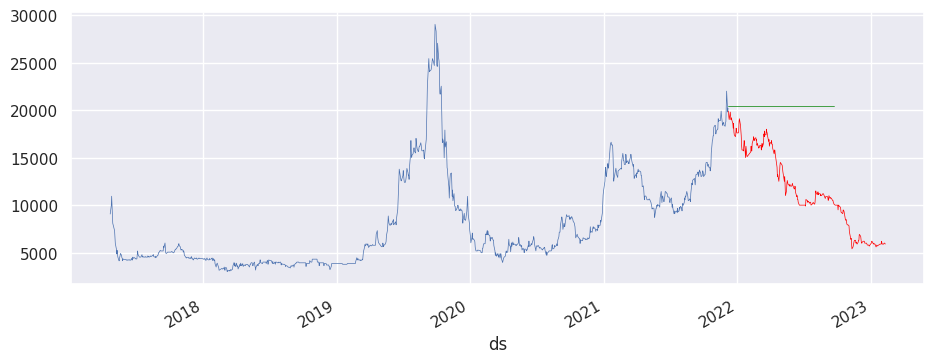

In [59]:
sns.set(rc={'figure.figsize':(11, 4)})
df_close_train.toPandas().set_index('ds').y.plot(linewidth=0.5)
df_close_test.toPandas().set_index('ds').y.plot(linewidth=0.5, c='red')
preds.set_index('ds').AutoARIMA.plot(linewidth=0.5, c='green')
plt.show()

In [60]:
preds.shape

(291, 3)

In [63]:
df_close_test.select("ds").show(10)

+-------------------+
|                 ds|
+-------------------+
|2022-07-11 17:00:00|
|2022-07-14 17:00:00|
|2022-06-23 17:00:00|
|2022-06-05 17:00:00|
|2022-12-06 17:00:00|
|2022-11-20 17:00:00|
|2022-12-04 17:00:00|
|2022-04-04 17:00:00|
|2022-12-13 17:00:00|
|2022-08-16 17:00:00|
+-------------------+
only showing top 10 rows

